In [378]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk 
from nltk import tokenize
from nltk.corpus import stopwords
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community  as nxcom

init_notebook_mode(connected=True)

nltk.download('stopwords')

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

[nltk_data] Downloading package stopwords to /home/lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [443]:
df = read_mongo(db="heartbeat", collection="meetup")

df["event_duration"] = df.apply(lambda row:  datetime.strptime(row.event_hour_end, "%H:%M") - datetime.strptime(row.event_time, "%H:%M:%S") , axis = 1) 
unique_groups = df["group_name"].unique()
edges = []
persons = []


In [445]:
for g in unique_groups:
    group_events = df[df.group_name == g]
    
    for index, row in group_events.iterrows():
        event_attendees = row['event_attendees']

        for person in event_attendees:
            person_obj = {
                "id":person["id"], 
                "name":person["name"], 
                "group":row["group_name"],
                "event":row["event_title"],
                "profile":person["web_actions"]["group_profile_link"], 
                "gender":person["gender"],
                "coords":row["coords"]
            }
            persons.append(person_obj)
                
            rel = (person["id"], row["group_name"])
            edges.append(rel)
            
persons_dataframe = pd.DataFrame(persons)            
G = nx.Graph()
G.add_nodes_from(unique_groups, node_color='r')
G.add_edges_from(edges)            
persons_df = pd.DataFrame(persons)            
print("finished processing")

finished processing


In [485]:
unique_edges = list(dict.fromkeys(person_group))

print("Total number of events detected: "+ str(len(df["event_title"].unique())))
print("Total number of groups detected: "+ str(len(unique_groups)))
print("Total number of people involved in Meetup Paris at this time: " + str(len(persons_df["id"].unique())))
genders=(persons_df['gender'].value_counts(normalize=True) * 100)
print(str(genders[0])+ "% of users are male")
print(str(genders[1])+ "% of users are female")
print("but we have been able to guess the gender of "+str(genders[2]) + "%")

Total number of events detected: 185
Total number of groups detected: 68
Total number of people involved in Meetup Paris at this time: 2273
38.52033852033852% of users are male
34.15233415233415% of users are female
but we have been able to guess the gender of 27.32732732732733%


Event title word data
paris         63
picnic        31
online        31
apprendre     28
night         26
              ..
bénévoles      6
'wine          5
promenade      5
privé          5
extérieur)     5
Length: 100, dtype: int64
Event description word data
paris          55
people         48
languages      44
language       41
every          37
               ..
faire           8
désinscrire     8
août,           7
temps           7
nouvelle        7
Length: 100, dtype: int64


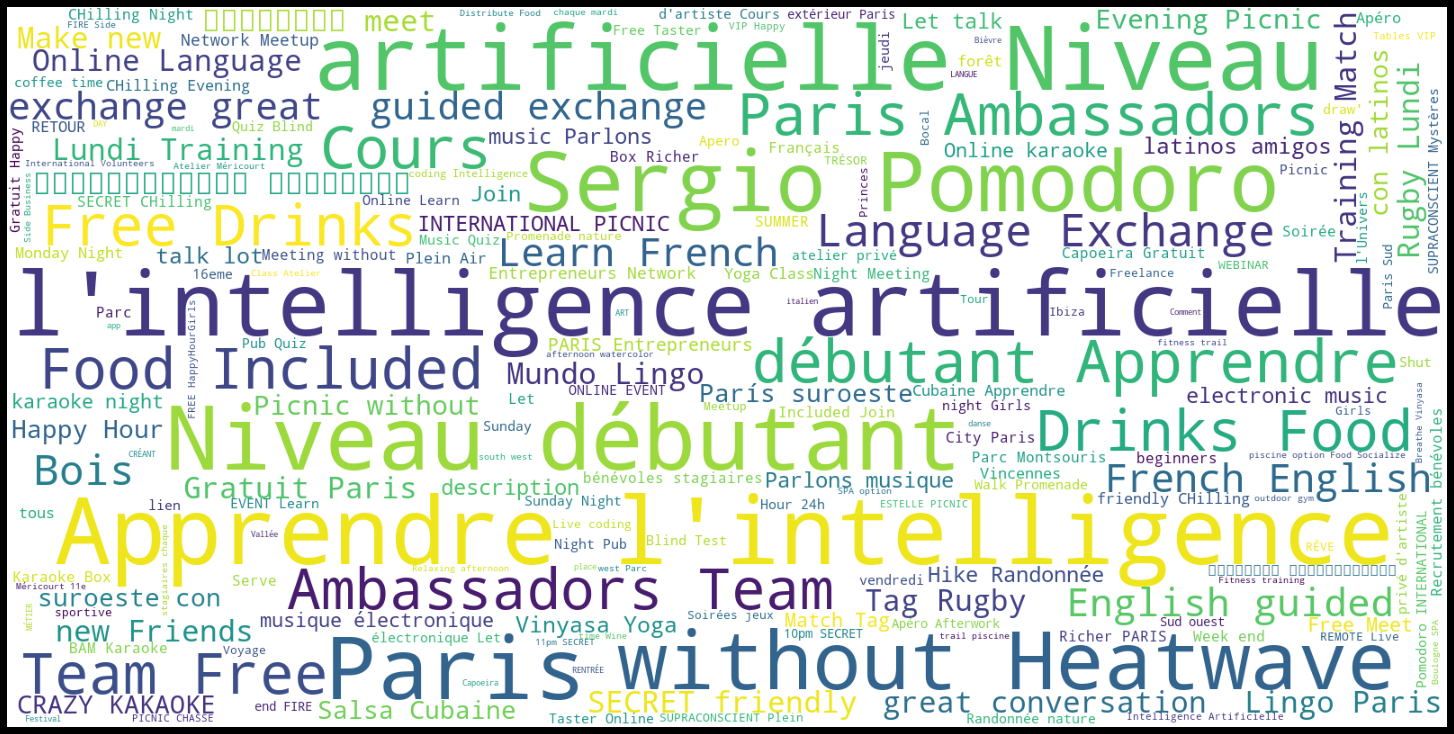

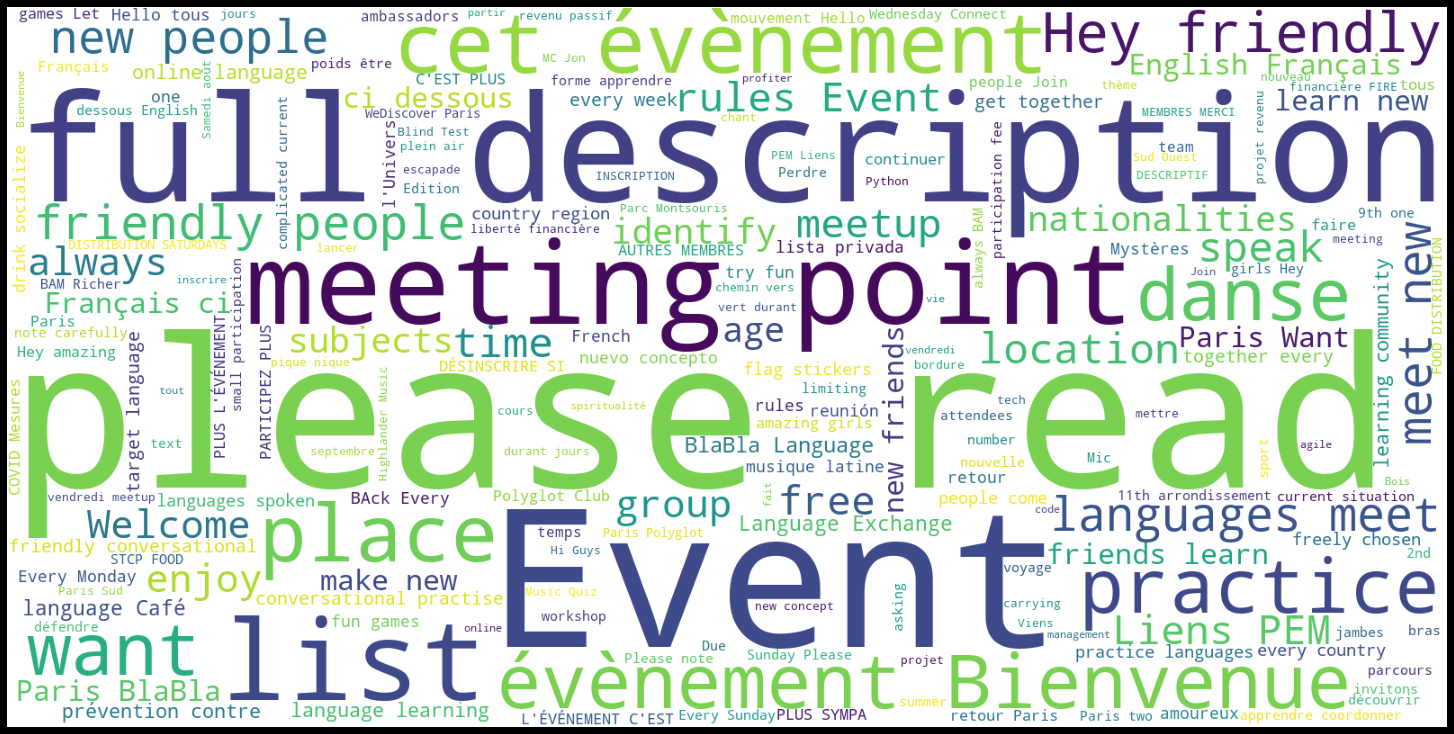

In [405]:
# TITLE/DESCRIPTION TEXT ANALYSIS
stopwords_fr = set(stopwords.words('french'))
stopwords_en = set(stopwords.words('english'))
spwords= stopwords_fr | stopwords_en 

print("Event title word data")
common = pd.Series(' '.join(df['event_title'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 4, i.split())))).lower().split()).value_counts()[:100]
print(common)

text = " ".join(review for review in df.event_title)

wordcloud = WordCloud(width=1600, height=800, stopwords=spwords,background_color="white").generate(text)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)


print("Event description word data")
common = pd.Series(' '.join(df['event_desc'].apply(lambda i: ' '.join(filter(lambda j: len(j) > 4, i.split())))).lower().split()).value_counts()[:100]
print(common)

text = " ".join(review for review in df.event_desc)

wordcloud = WordCloud(width=1600, height=800, stopwords=spwords,background_color="white").generate(text)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)



In [483]:
# Number of communities, communities may or may not be related to group
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The meetup Paris network contains {len(communities)} communities.")
#302558731
for i in communities:
    contains = 301140745 in i
    if contains:
        break

edges = []
for n in i:
    rel = (302558731, n)
    edges.append(rel)
    
nodes = list(i)

print(nodes)
G2 = nx.Graph()
G2.add_nodes_from(nodes, node_color='r')
G2.add_edges_from(edges)
# sample visualization extracted from documentation, it works but looks ugly and hard to read
pos = nx.spring_layout(G2)
for n, p in pos.items():
    G2.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#FFF'),
    hoverinfo='none',
    mode='lines')

for edge in G2.edges():
    x0, y0 = G2.nodes[edge[0]]['pos']
    x1, y1 = G2.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    showlegend = False,
    
    marker=dict(
        color=[],
        size=18,
        colorbar=dict(
            thickness=10,
            title='Node Community',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G2.nodes():
    x, y = G2.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])    

for node, adjacencies in enumerate(G2.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0])
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Meetup Paris network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)


The meetup Paris network contains 35 communities.
[303859713, 288890372, 270236168, 303284749, 311297553, 229682712, 229751322, 266273310, 291921953, 297712677, 212430887, 304236071, 'Paris-Artificial-Intelligence-Deep-Learning', 11427374, 260505144, 200156729, 305733183, 173287492, 205404229, 311829068, 185548372, 211093080, 197686881, 120851042, 65953892, 268140646, 305514598, 118563432, 258061414, 302916710, 234036846, 43295342, 305409654, 266329210, 314114179, 240842376, 302059145, 26368142, 211271825, 150956692, 100288152, 111093402, 68839072, 244079780, 280486565, 13994150, 225222312, 306015921, 265232566, 252369079, 245254845, 303474890, 108607182, 142336722, 292132054, 207170265, 210563296, 206220000, 183949030, 156495592, 'IBM-Cloud-Paris-Meetup', 255826156, 205910258, 266833140, 306352889, 92067072, 301687553, 188480259, 263432965, 13454088, 301140745, 279984393, 238245133, 312610574, 221795607, 203348763, 297436956, 283377444, 34975012, 259632423, 311588154, 263988540, 19282

In [413]:
# sample visualization extracted from documentation, it works but looks ugly and hard to read
pos = nx.spring_layout(G, k=0.05)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=8,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])    

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Meetup Paris network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)


NameError: name 'plotly' is not defined

In [262]:
# groups with more events / locations with more events
top_groups = df['group_name'].value_counts()[:10].index.tolist()
top_locations = df['event_location'].value_counts()[:10].index.tolist()

print("Locations with more events")
print(top_locations)
print("Groups that offer more events")
print(top_groups)


Locations with more events
['Événement en ligne', 'unknown', 'Le Piano Vache', 'Vincennes ', 'Plaine Mortemart/Pershing', 'The Highlander Scottish Pub Paris', 'Bar la Maizon', 'Ground Control', 'DENFERT Café', 'Studio Massaro']
Groups that offer more events
['Dhaki-Data', 'meetup-group-SsrSLrps', 'promenades-et-randonnees', 'Paris-Tag-Rugby-Meetup', 'GirlsofParis', 'International-Afterworks-in-Paris-MeetnTrip', 'YESandYEP', 'POTES-DE-SORTIES', 'PARIS-Entrepreneurs-Network-PEN', 'LingUppParis']


In [263]:
# groups that mobilize the most people. Agg sum of attendees in all available events
df['num_attendees']  = (df['event_attendees'].str.len())
df['num_comments']  = (df['event_comments'].str.len())

print("Groups that mobilize more people")
top_people = df.groupby(['group_name'])["num_attendees"].agg('sum').reset_index()
top_people = top_people.sort_values('num_attendees', ascending=False)
print(top_people)

print("Groups that generate more online comments")
top_comments = df.groupby(['group_name'])["num_comments"].agg('sum').reset_index()
top_comments = top_comments.sort_values('num_comments', ascending=False)
print(top_comments)

print("Most popular time frames")
top_timeframes = df.groupby(['event_time'])["event_id"].count()
top_timeframes = top_timeframes.sort_values(ascending=False)
print("Most popular start_hours")
print(top_timeframes[:5])

print("Top event durations")
top_durations = df.groupby(['event_duration'])["event_id"].count()
top_durations = top_durations.sort_values(ascending=False)
print("Most popular start_hours")
print(top_durations[:5])

Groups that mobilize more people
                                     group_name  num_attendees
66                     promenades-et-randonnees            264
21                                  LEPARISAFRO            206
17                       IBM-Cloud-Paris-Meetup            171
8                                  Events-Paris            166
6                                     DDD-Paris            163
..                                          ...            ...
51  United-Spirit-Developpement-personnel-Paris             11
43                            Pub-Quiz-in-Paris              9
24               Le-Wagon-Paris-Coding-Bootcamp              9
9                       ExpatriesTriathlonParis              5
31                         Novaa-Freelance-Talk              4

[68 rows x 2 columns]
Groups that generate more online comments
                                       group_name  num_comments
66                       promenades-et-randonnees            11
37                

In [264]:
# Get percentages of men/women per event
def attendees_women(row, gender="women"):
    num_total = 0
    num_men = 0
    num_wom = 0
    for a in row["event_attendees"]:
        num_total += 1
        if a["gender"] == "male":
            num_men += 1
        elif a["gender"] == "female":
            num_wom += 1

    per_wom = num_wom / num_total
    per_men = num_men / num_total
    if gender == "women":
        return per_wom
    elif gender == "men":
        return per_men

In [265]:
# Get percentages of men/women per event
df['attendees_women'] = df.apply(lambda row: attendees_women(row), axis=1)
df['attendees_men'] = df.apply(lambda row: attendees_women(row, gender="men"), axis=1)
print("Events with higher % women")
print(df[df["num_attendees"]>10].sort_values('attendees_women',ascending=False)[["event_title","attendees_women"]])
print("Events with higher % women")
print(df[df["num_attendees"]>10].sort_values('attendees_men',ascending=False)[["event_title","attendees_men"]])

Events with higher % women
                                           event_title  attendees_women
20   Monet, Renoir, Chagall - L'Atelier des Lumière...         0.615385
352     Cabourg : Plage & Architecture - LONG DAY TRIP         0.600000
256    Ready-Set-Write!   (ambitious mid-week session)         0.571429
385  TEACH ENGLISH OR FRENCH TO PARIS REFUGEES & PR...         0.562500
245  Visite de l'Expo "Jusqu'ici tout va bien" au P...         0.551724
..                                                 ...              ...
191  Three ways to deploy a Python app into a Red H...         0.071429
284                                DDD clinic (online)         0.055215
211  Synthetic pitch - Centre Sportif Suzanne Lengl...         0.037037
303                Basketball - Bir-hakeim-Tour Effeil         0.000000
265  WEBINAR : Freelances, découvrez le Portage Sal...         0.000000

[83 rows x 2 columns]
Events with higher % women
                                           event_title  att

In [266]:
# Number of communities, communities may or may not be related to group
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The meetup Paris network contains {len(communities)} communities.")
print(communities)

The meetup Paris network contains 35 communities.
[frozenset({312260096, 263402496, 212217346, 130064902, 255395847, 313908744, 282822155, 298440716, 301200402, 252036626, 251874324, 42915352, 'promenades-et-randonnees', 287281184, 213034528, 278759969, 289249320, 201182250, 232713258, 253458476, 303548975, 311263283, 59726902, 264485944, 8009784, 279764538, 12277311, 283242561, 187107906, 10807874, 221726284, 284261453, 313690192, 314311248, 256811090, 297775189, 273941590, 209192023, 267226200, 310419547, 55243872, 276367456, 232651878, 281871463, 125836392, 284490857, 311991915, 261907565, 199453807, 260202095, 310254705, 279480948, 275530871, 313561207, 314170490, 310158975, 201126528, 284292225, 226896007, 311000715, 298849420, 8824976, 274819216, 244385426, 297463444, 314605206, 313415831, 284781209, 207739548, 311768733, 145547932, 244303010, 311038115, 312997544, 311790250, 283934890, 278882477, 12894383, 217737394, 9757875, 253356211, 287211700, 266971318, 305442490, 167999162

In [364]:
# MAP POINTS 
# Problem! We need to do a bunch (un necessary) of data transformations here!!!
# Solutions, find a more intelligent way to send lat/long to plotly
# Store lat/long as separate fields in the scrapper...
df_geo = df[df['coords'].str.len() > 0]

#mnyeeeee
df_geo[['lat','lon']] = pd.DataFrame(df_geo['coords'].tolist(),index=df_geo.index)


top_coords = df.groupby(df_geo['coords'].map(tuple))['event_id'].count().to_frame('count').reset_index()
top_coords[['lat','lon']] = pd.DataFrame(top_coords['coords'].tolist(),index=top_coords.index)

mapbox_at= "pk.eyJ1IjoiY3VyYXNhbzk5IiwiYSI6ImNrZTl2eTJpeDJhaDEzN243YXdjY24zN20ifQ.cRm0go3r-tdZdTU-GBQitw"


# POINT (SCATTER) MAP

fig = px.scatter_mapbox(df_geo, lat="lat", lon="lon", color="group_name", size="num_attendees",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, center=dict(lat=48.864, lon=2.349), zoom=12)
fig.show()

# HEAT DENSITY MAP

#px.set_mapbox_access_token(mapbox_at)

fig = px.density_mapbox(top_coords, lat="lat", lon="lon", z="count", radius=12,
                        center=dict(lat=48.864, lon=2.349), zoom=9)


fig.update_layout(mapbox_style="dark", mapbox_accesstoken=mapbox_at)
fig.show()

/home/lab/.local/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [402]:
# Mapping the most frequent zones for a particular user
particular_user = 314006705
df_geo = df[df['coords'].str.len() > 0]

target_df = persons_df[ (persons_df["id"] == particular_user) & (persons_df['coords'].str.len() > 0)]
target_zone = target_df.groupby(target_df['coords'].map(tuple))['id'].count().to_frame('count').reset_index()
target_zone[['lat','lon']] = pd.DataFrame(target_zone['coords'].tolist(),index=target_zone.index)

print(target_zone.head())

fig = px.density_mapbox(target_zone, lat="lat", lon="lon", z="count", radius=12,
                        center=dict(lat=48.864, lon=2.349), zoom=9)


#fig.update_layout(mapbox_style="dark", mapbox_accesstoken=mapbox_at)
fig.show()

                             coords  count        lat       lon
0  (48.8543392, 2.3579307601703112)      2  48.854339  2.357931
1           (48.8616449, 2.3808442)      2  48.861645  2.380844


In [365]:
# Definition: Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
print("Betweenness centrality")
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
for influencer in top_influencers:
    print("User id: "+str(influencer)+" Betweenness centrality coef: "+str(betCent.get(influencer)))

Betweenness centrality
User id: 314006705 Betweenness centrality coef: 0.08742837064115216
User id: 313399083 Betweenness centrality coef: 0.08656252128352364
User id: 224240227 Betweenness centrality coef: 0.05918958794688026
User id: 211271825 Betweenness centrality coef: 0.04704769554358367
User id: 314503967 Betweenness centrality coef: 0.03799821200659664


In [52]:
# Definition: Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
print("Degree centrality")
betCent = nx.degree_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
for influencer in top_influencers:
    print("User id: "+str(influencer)+ "("+persons[influencer]["name"]+") Degree centrality coef: "+str(betCent.get(influencer)) + " User profile: "+str(persons[influencer]["web_actions"]["group_profile_link"]))
    #print("User id: "+str(influencer)+" Connections: ")
    #print(str(G.edges(influencer)))

Degree centrality
User id: 314006705(Flore P.) Degree centrality coef: 0.002564102564102564 User profile: https://www.meetup.com/Events-Paris/members/314006705
User id: 211271825(Saad G.) Degree centrality coef: 0.002564102564102564 User profile: https://www.meetup.com/FIRE-France-un-chemin-vers-lautonomie/members/211271825
User id: 279942924(Aby) Degree centrality coef: 0.002136752136752137 User profile: https://www.meetup.com/Slovenians-in-Paris/members/279942924
User id: 314257294(Myriam) Degree centrality coef: 0.002136752136752137 User profile: https://www.meetup.com/PolyglotClub-Paris/members/314257294
User id: 313399083(Essaadi) Degree centrality coef: 0.002136752136752137 User profile: https://www.meetup.com/Events-Paris/members/313399083


In [53]:
# EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.
# By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.
print("Eigenvector centrality")
betCent = nx.eigenvector_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
for influencer in top_influencers:
    print("User id: "+str(influencer)+ "("+persons[influencer]["name"]+") Degree centrality coef: "+str(betCent.get(influencer)) + " User profile: "+str(persons[influencer]["web_actions"]["group_profile_link"]))
    #print("User id: "+str(influencer)+" Connections: ")
    #print(str(G.edges(influencer)))

Eigenvector centrality
User id: 55243872(Christophe P.) Degree centrality coef: 0.05917075312261184 User profile: https://www.meetup.com/Events-Paris/members/55243872
User id: 59726902(Géraldine) Degree centrality coef: 0.05917075312261184 User profile: https://www.meetup.com/Events-Paris/members/59726902
User id: 297999354(Feriel) Degree centrality coef: 0.05639518165245691 User profile: https://www.meetup.com/Weekends-en-Europe/members/297999354
User id: 187312254(nanouche007) Degree centrality coef: 0.055822079072851534 User profile: https://www.meetup.com/YESandYEP/members/187312254
User id: 314307123(Djohra O.) Degree centrality coef: 0.05551727680314575 User profile: https://www.meetup.com/Events-Paris/members/314307123


In [54]:
# Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.
# This measure calculates the shortest paths between all nodes, then assigns each node a score based on its sum of shortest paths.
print("Closeness centrality")
betCent = nx.closeness_centrality(G)
influencers = [ elem for elem in betCent if elem not in unique_groups] 
calced = (sorted(influencers, key=betCent.get, reverse=True))
top_influencers = (calced[:5])
for influencer in top_influencers:
    print("User id: "+str(influencer)+ "("+persons[influencer]["name"]+") Degree centrality coef: "+str(betCent.get(influencer)) + " User profile: "+str(persons[influencer]["web_actions"]["group_profile_link"]))
    #print("User id: "+str(influencer)+" Connections: ")
    #print(str(G.edges(influencer)))

Closeness centrality
User id: 313399083(Essaadi) Degree centrality coef: 0.24831747660309234 User profile: https://www.meetup.com/Events-Paris/members/313399083
User id: 314006705(Flore P.) Degree centrality coef: 0.24718062195457186 User profile: https://www.meetup.com/Events-Paris/members/314006705
User id: 297999354(Feriel) Degree centrality coef: 0.2329432740823098 User profile: https://www.meetup.com/Weekends-en-Europe/members/297999354
User id: 211271825(Saad G.) Degree centrality coef: 0.2326922846694423 User profile: https://www.meetup.com/FIRE-France-un-chemin-vers-lautonomie/members/211271825
User id: 187312254(nanouche007) Degree centrality coef: 0.23264215167694646 User profile: https://www.meetup.com/YESandYEP/members/187312254
